# Assignment 02 - Logistic Regression Model for Fraudulent Insurance Claims
# Prepared by: Mohammad Tayyab Alam
- ERP 24157

# **Acknowledgements**
- Generative AI models such as DeepSeek , OpenAI's ChatGPT 4o and Claude were used to improve the model.
- Assistance from generative AI was taken to fix python code errors.
- Assistance from generative AI was taken to write complex python codes.
- Ideas for feature engineering were discussed with AI.
- All analysis in the markdown format is my own original work and analysis of the code and my understanding of the model and the work that I have done.
- Attempts to improve the model and troubleshooting were a mixture of research on github , stackoverflow and kaggle alongside AI help.



---

- The Class collab file called 08/03_Nibaf_Ecommerce_fraud.ipynb was referred to create the undersampling code.
- Ideas for the layout of the notebook were taken as an inspiration from it
- The plotting code was referrenced but then AI was used to create a better loop that is dynamic to plot all confusion matrixes and box plots


#Introduction
This notebook involves the following (analysis are provided later in depth):
- **Data loading**  
  - Importing libraries
  - Importing data
- **Data Preprocessing and Exploratory Data Analysis (EDA)**
  - Printing information about the raw data set via df.info()
  - Checking for missing values
  - Summarizing the key statistics
  - Checking the target variable (Fraud) distribution
  - Plotting a box plot for all the numerical columns to identify outliers and data patterns.
  - A correlation heatmap was plotted to check for correlation between the numerical variables and the target variable (Fraud).
  - Identifying anomalies in data such as repeated vehicle number plate for different vehicle type. This is used to create a feature later.
  - Duplicate checking
  - Checking Unique Values
  - Dropping identifier columns
  - One Hot Encoding
- Model Training and Analysis before Feature Engineering
  - Stratified Test Train Split (70:30)
  - Conducting Raw Logistic Regression without Class Imbalance (Control)
  - SMOTE Imbalance Dealing Model Training
  - Automatic Undersampling (python built in code - suggested by OpenAI's Chat GPT 4o)
  - Cost Sensitive Model Training
  - Class Weight Model Training
  - Undersampling as per the method in 08/03_Nibaf_Ecommerce_fraud class lecture
- Feature Engineering
- Model Training and Analysis after Feature Engineering
  - Stratified Test Train Split (70:30)
  - Conducting Raw Logistic Regression without Class Imbalance with (Control)
  - SMOTE Imbalance Dealing Model Training
  - Automatic Undersampling (python built in code - suggested by OpenAI's Chat GPT 4o)
  - Cost Sensitive Model Training
  - Class Weight Model Training
  - Undersampling as per the method in 08/03_Nibaf_Ecommerce_fraud class lecture
  - Running the undersampled class model on full dataset
  - Creating a table of results
  - Printing the best model
  - Checking for Potential Data Leakage via Correlation
  - Regularization
- Attempts to Improve Model
  - Identifying the best possible thresholds based on goals
  - Adjusting the weight for minority class

# Data Loading

## Importing Libraries
- All the libraries that are necessary for this logistic regression model to run are imported
- The insurance claims data set is loaded

In [1]:
# Importing all the libraries used in the entire notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix
)

from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import classification_report
from collections import Counter
from sklearn.metrics import roc_curve

# Loading the file from google collab upload option
file_path = "insurance_claims.csv"
df = pd.read_csv(file_path)


# Data Pre Processing and Exploratory Data Analysis (01 Mark)
- Data set info
  - We can see that the raw data set contains 26 columns out of which 25 are our potential predictors.
  - When we look closely we can immediately rule out PolicyholderNumber and ReferenceId column and drop it as they are irrelevant for predicting
  - Total potential predictors are now 23
  - There are 12 object data types. This means that they are strings / not in number format and we need to convert them via dummy variable method to make them compatible with logistic regression.
  - Float and integer columns should be checked for outliers.
- Missing Values
  - We have no missing values in any column which saves us time.

In [2]:
# Basic Information & Missing Values
print("Dataset Info:")
df.info()
print("\nMissing Values:")
print(df.isnull().sum())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 26 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   PolicyholderNumber                10000 non-null  object 
 1   FirstPartyVehicleNumber           10000 non-null  object 
 2   PolicyholderOccupation            10000 non-null  object 
 3   FirstPolicySubscriptionDate       10000 non-null  object 
 4   FirstPartyVehicleType             10000 non-null  object 
 5   PolicyholderPostCode              10000 non-null  int64  
 6   PolicyWasSubscribedOnInternet     10000 non-null  int64  
 7   NumberOfPoliciesOfPolicyholder    10000 non-null  int64  
 8   FpVehicleAgeMonths                10000 non-null  int64  
 9   PolicyHolderAge                   10000 non-null  int64  
 10  FirstPartyLiability               10000 non-null  float64
 11  ReferenceId                       10000 non-null  obje

## Summary Statistics
## PolicyholderPostcode
  - This is a location based column which has post codes in number format. The summary statistic of this column is not relevant for analysis but has been included here for completeness.

## PolicyWasSubscribedOnInternet

  - The mean value shows that 29% of the policies were subscribed via internet and the remainder offline. This variable is worth keeping for fraud analysis as it can show trends in offline vs online fraud tendency.
  - It is a binary variable so min is 0 and max is 1

## NumberOfPoliciesOfPolicyholder

  - Most policyholders have 1 to 2 policies indicated by mean with the highest at 4 -> could be an outlier

## FpVehicleAgeMonths

  - Vehicles are on average 10 years old.
  - The range is from 1 month to nearly 20 years.

## PolicyHolderAge

- Policyholders are mostly middle-aged (33-64 years), with a minimum of 18 years.

## FirstPartyLiability

- Liability varies widely (range: 0.1 to 0.9)
- Average is almost 50% suggesting that 50% of liability falls on the client in most claims

## DamageImportance

- Average value is 5.

## EasinessToStage

- Shows how difficult it is to replicate a claim.

## ClaimWithoutIdentifiedThirdParty

- The summary shows that only very few claims were without an identified third party (self claims).

## ClaimAmount

- Average claim amount is $25208. Useful for setting a line between too much and too less.

## LossHour

- On average claims occur at 11pm

## NumberOfBodilyInjuries

- Most claims dont have bodily injuries shown by median. Some do which need to be looked at for exaggeration.

## Fraud

- Our target variable

In [3]:
# Generating summary stats
print("\nSummary Statistics:")
print(df.describe())



Summary Statistics:
       PolicyholderPostCode  PolicyWasSubscribedOnInternet  \
count          10000.000000                    10000.00000   
mean           55160.097100                        0.29040   
std            26257.617614                        0.45397   
min            10010.000000                        0.00000   
25%            31798.250000                        0.00000   
50%            55844.000000                        0.00000   
75%            78056.250000                        1.00000   
max            99998.000000                        1.00000   

       NumberOfPoliciesOfPolicyholder  FpVehicleAgeMonths  PolicyHolderAge  \
count                    10000.000000        10000.000000     10000.000000   
mean                         1.596800          120.534600        48.520900   
std                          0.857265           69.264548        17.764237   
min                          1.000000            1.000000        18.000000   
25%                          1

## Class Distribution
- We can see that there is severe imbalance in the data with only 1% of the data being our target that we are trying to predict.
- There is very little data for the model to learn from regarding frauds.
- Undersampling or adjustments are important.

In [4]:
# calculating class distribution
class_distribution = df['Fraud'].value_counts(normalize=True) * 100
print("\nClass Distribution:")
print(class_distribution)


Class Distribution:
Fraud
0.0    99.0
1.0     1.0
Name: proportion, dtype: float64


## Plotting class distribution in bar chart

<ipython-input-5-633f7a4ee482>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_distribution.index, y=class_distribution.values, palette="coolwarm")


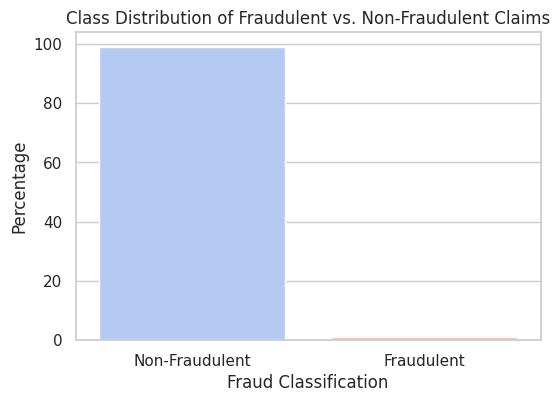

In [5]:
# Setting style for visualization for consistency
sns.set(style="whitegrid")

# graphinh class distribution
plt.figure(figsize=(6, 4))
sns.barplot(x=class_distribution.index, y=class_distribution.values, palette="coolwarm")
plt.xlabel("Fraud Classification")
plt.ylabel("Percentage")
plt.title("Class Distribution of Fraudulent vs. Non-Fraudulent Claims")
plt.xticks([0, 1], ["Non-Fraudulent", "Fraudulent"])
plt.show()


## Box Plots
- Box Plots help identify outliers such as those in number of bodily injuries


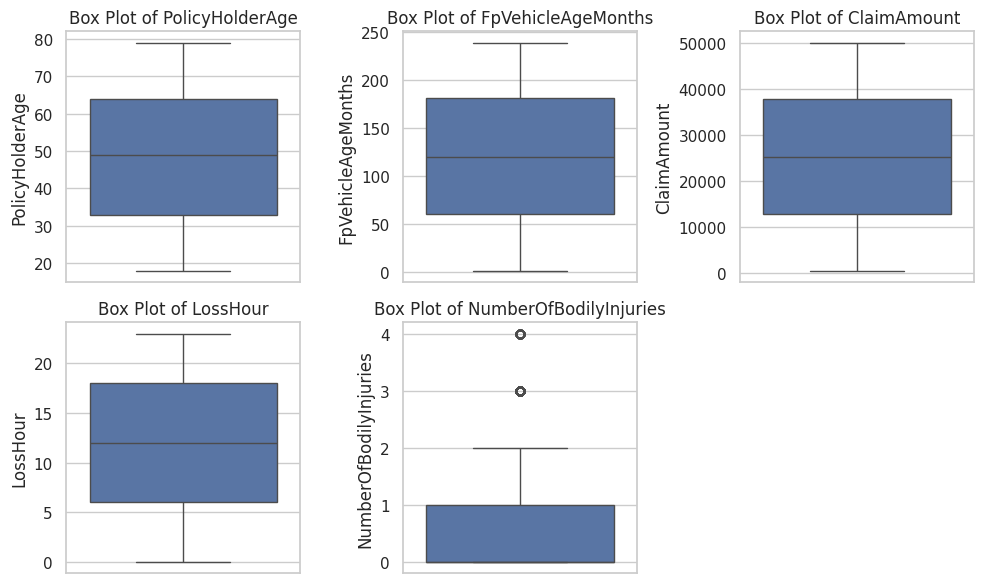

In [6]:
# Creating a box plot for numerical columns in the data
numerical_columns = ['PolicyHolderAge', 'FpVehicleAgeMonths', 'ClaimAmount', 'LossHour', 'NumberOfBodilyInjuries']
plt.figure(figsize=(10, 6))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(df[column])
    plt.title(f"Box Plot of {column}")
    plt.tight_layout()

plt.show()

## Correlation Heatmap
- We can see that there are no strong predictors in the data set.
- Feature engineering can adress this.

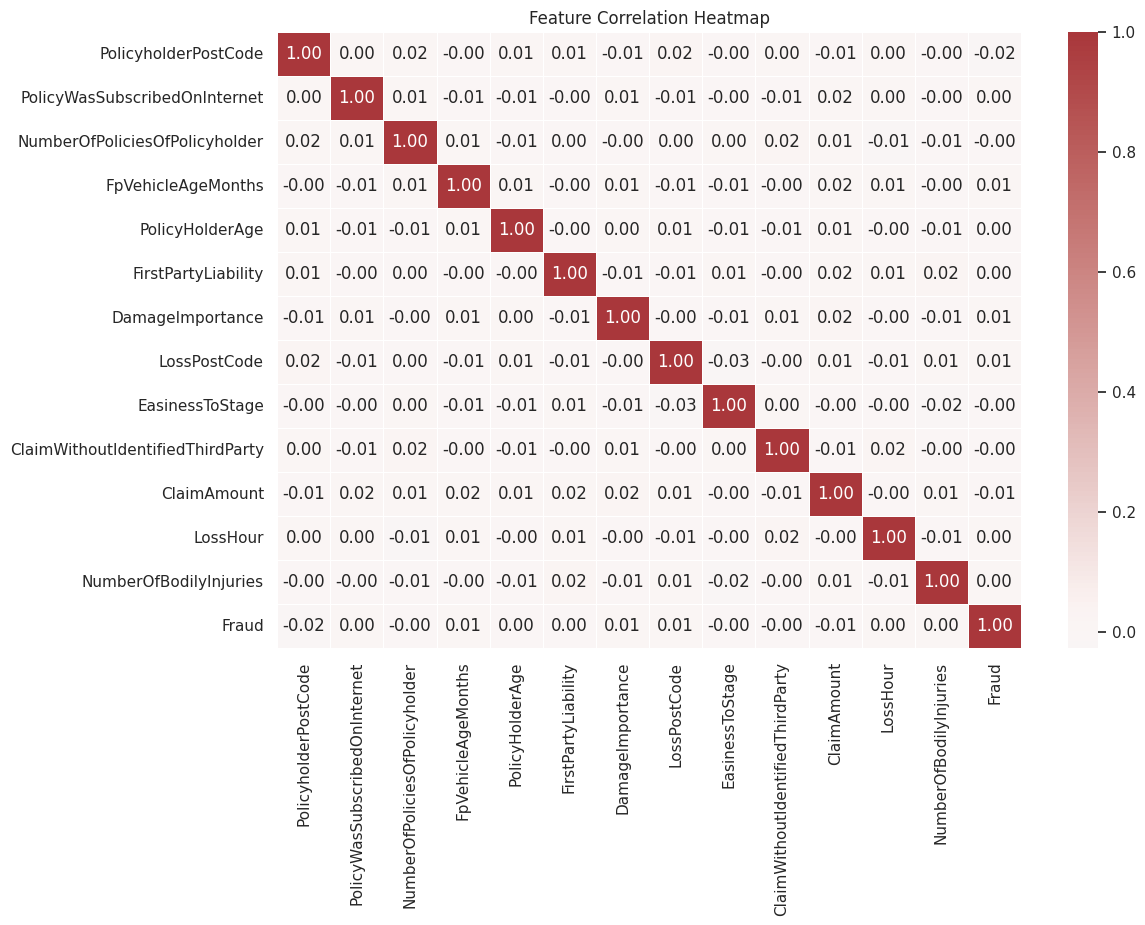

In [7]:
# Creating a correl heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(numeric_only=True), cmap="vlag", annot=True, fmt=".2f", linewidths=0.5, center=0)
plt.title("Feature Correlation Heatmap")
plt.show()

## Identifying an anomaly
- Checking if the same number plate is being used for different vehicle type?
- if yes identify this as a descrepency to avoid problems in future feature engineering

In [8]:
# Investigating inconsistencies in First Party Vehicle Type
first_party_inconsistencies = (
    df.groupby('FirstPartyVehicleNumber')['FirstPartyVehicleType']
    .nunique()
    .reset_index()
)

# renaming the columns
first_party_inconsistencies.columns = ['FirstPartyVehicleNumber', 'UniqueVehicleTypes']

# filtering for vehciles sharing the same number plates
inconsistent_vehicles = first_party_inconsistencies[first_party_inconsistencies['UniqueVehicleTypes'] > 1]

# output
if not inconsistent_vehicles.empty:
    print("The following FirstPartyVehicleNumbers are associated with multiple vehicle types:")
    print(inconsistent_vehicles)
    print(f"\nTotal count of inconsistent FirstPartyVehicleNumbers: {len(inconsistent_vehicles)}")
else:
    print("No FirstPartyVehicleNumbers are associated with multiple vehicle types.")


The following FirstPartyVehicleNumbers are associated with multiple vehicle types:
     FirstPartyVehicleNumber  UniqueVehicleTypes
30                    V10336                   2
44                    V10540                   2
87                    V10942                   2
109                   V11110                   2
125                   V11267                   2
...                      ...                 ...
9338                  V98918                   2
9386                  V99353                   2
9392                  V99417                   2
9431                  V99780                   2
9434                  V99816                   2

[429 rows x 2 columns]

Total count of inconsistent FirstPartyVehicleNumbers: 429


## Checking duplicates

In [9]:
# Checking duplicates
duplicate_summary = df.apply(lambda x: x.duplicated().sum())
print("Duplicate counts per column:\n", duplicate_summary)

Duplicate counts per column:
 PolicyholderNumber                     0
FirstPartyVehicleNumber              533
PolicyholderOccupation              9994
FirstPolicySubscriptionDate         6319
FirstPartyVehicleType               9995
PolicyholderPostCode                 518
PolicyWasSubscribedOnInternet       9998
NumberOfPoliciesOfPolicyholder      9996
FpVehicleAgeMonths                  9761
PolicyHolderAge                     9938
FirstPartyLiability                    0
ReferenceId                            0
ThirdPartyVehicleNumber              549
InsurerNotes                        9996
LossDate                            9269
ClaimCause                          9995
ClaimInvolvedCovers                 9996
DamageImportance                    9991
ConnectionBetweenParties            9998
LossPostCode                         547
EasinessToStage                        0
ClaimWithoutIdentifiedThirdParty    9998
ClaimAmount                            0
LossHour                   

## Checking Unique Values

In [10]:
# Checking the cardinality of categorical variables
categorical_columns = df.select_dtypes(include=['object']).columns

# checkign the unique values
cardinality = df[categorical_columns].nunique()
print(cardinality)

PolicyholderNumber             10000
FirstPartyVehicleNumber         9467
PolicyholderOccupation             6
FirstPolicySubscriptionDate     3681
FirstPartyVehicleType              5
ReferenceId                    10000
ThirdPartyVehicleNumber         9451
InsurerNotes                       4
LossDate                         731
ClaimCause                         5
ClaimInvolvedCovers                4
ConnectionBetweenParties           2
dtype: int64


- We can't one hot encode highly cardinal columns so we will need to drop them.
- Threshold set at 10 unique items

In [11]:
# Identifying variables with high cardinality (I have defined it as being more than 10)
high_cardinality_columns = cardinality[cardinality > 10]

high_cardinality_columns

,0
PolicyholderNumber,10000
FirstPartyVehicleNumber,9467
FirstPolicySubscriptionDate,3681
ReferenceId,10000
ThirdPartyVehicleNumber,9451
LossDate,731


## Dropping the high cardinality columns

In [12]:
# Dropping high cardinal columns
data=df.copy()
drop_columns = ['PolicyholderNumber', 'FirstPartyVehicleNumber', 'ReferenceId', 'ThirdPartyVehicleNumber','LossDate']
data_cleaned = data.drop(columns=drop_columns)

## Selecting variables to encode
- Logistic regression requires numerical data so catagorical are converted to dummy

In [13]:
#anything below or equal to 10 is low cardinality
low_cardinality_columns = cardinality[cardinality <=10 ]
print(low_cardinality_columns)

PolicyholderOccupation      6
FirstPartyVehicleType       5
InsurerNotes                4
ClaimCause                  5
ClaimInvolvedCovers         4
ConnectionBetweenParties    2
dtype: int64


## Connection Between Parties is Yes or No so converting it to 0 or 1

In [14]:
# Converting the 'ConnectionBetweenParties' column to binary (1 for 'Yes', 0 for 'No')
data_cleaned['ConnectionBetweenParties'] = data['ConnectionBetweenParties'].apply(lambda x: 1 if x == 'Yes' else 0)

print(data_cleaned[['ConnectionBetweenParties']].head())


   ConnectionBetweenParties
0                         0
1                         0
2                         0
3                         0
4                         0


In [15]:
# One-hot encoding
variables_to_encode = ['PolicyholderOccupation', 'ClaimInvolvedCovers', 'FirstPartyVehicleType', 'InsurerNotes', 'ClaimCause']
data_encoded = pd.get_dummies(data_cleaned, columns=variables_to_encode, drop_first=True, dtype=int)

data_encoded

,FirstPolicySubscriptionDate,PolicyholderPostCode,PolicyWasSubscribedOnInternet,NumberOfPoliciesOfPolicyholder,FpVehicleAgeMonths,PolicyHolderAge,FirstPartyLiability,DamageImportance,ConnectionBetweenParties,LossPostCode,...,FirstPartyVehicleType_SUV,FirstPartyVehicleType_Truck,FirstPartyVehicleType_Van,InsurerNotes_Partial damage,InsurerNotes_Theft reported,InsurerNotes_Total loss,ClaimCause_Fire,ClaimCause_Natural Disaster,ClaimCause_Theft,ClaimCause_Vandalism
0,2014-02-16,75165,0,2,76,31,0.121587,5,0,81328,...,0,0,0,0,0,1,1,0,0,0
1,2011-09-14,45809,1,1,97,67,0.612870,8,0,88724,...,0,0,0,1,0,0,0,0,0,1
2,2015-10-11,42165,0,1,176,76,0.871980,1,0,68441,...,0,1,0,1,0,0,0,1,0,0
3,2016-04-12,82232,0,1,151,71,0.500794,9,0,44767,...,0,0,0,0,1,0,1,0,0,0
4,2012-06-27,85642,0,1,81,28,0.771998,8,0,46852,...,1,0,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2015-07-26,80283,1,2,219,43,0.745130,7,0,16775,...,1,0,0,1,0,0,0,1,0,0
9996,2018-10-08,73266,0,1,234,18,0.553707,7,0,34755,...,0,1,0,1,0,0,0,1,0,0
9997,2013-07-06,41869,0,1,82,31,0.388769,8,0,60380,...,0,0,1,0,0,0,0,1,0,0
9998,2016-01-22,84349,0,1,49,22,0.877165,2,0,17804,...,0,0,0,0,0,1,0,0,0,0


# Handling Class Imbalance (02 Marks) + Logistic Regression Models (02 Marks) [4 Marks Total]

## Model Training and Analysis before Feature Engineering


### Defining X and Y and dropping irrelevant variables and the target from X
- Using stratified test train split at 70:30
- Stratified used to address class imbalance
- Printing the test and train sizes

In [16]:
X = data_encoded.drop(columns=['Fraud', 'FirstPolicySubscriptionDate'])
y = data_encoded['Fraud']

In [17]:
# Train-test split with stratification
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)


In [18]:
# Print the size of each split
print(f"Size of X_train: {X_train_raw.shape}")
print(f"Size of X_test: {X_test_raw.shape}")
print(f"Size of y_train: {y_train_raw.shape}")
print(f"Size of y_test: {y_test_raw.shape}")

Size of X_train: (7000, 33)
Size of X_test: (3000, 33)
Size of y_train: (7000,)
Size of y_test: (3000,)


### Training the logistic regression model without class imbalance and feature engineering to act as control for testing the impact of class imbalance and feature engineering

In [19]:
# Control Model - Log reg without imbalance or features
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_raw, y_train_raw)
y_pred_raw_noimbalance = log_reg.predict(X_test_raw)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Defining a function to calculate the key metrics to evaluate every model based on accuracy , precission , recall (our top priority) , f1 score, auc and roc and plotting a confusion matrix

In [20]:
# function for metrics
def evaluate_model(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc_roc = roc_auc_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    return accuracy, precision, recall, f1, auc_roc, cm

### Evaluating the logistic model and storing results in a list which will be converted to dataframe later for easier comparission!
- We can see that the logistic regression model without any imbalance handling and feature engineering is unable to predict any fraud cases.
- Even thought the accuracy is 99% it is irrelevant to us as we would loose money due to fraud which would go unnoticed

In [21]:
# evaluating the model
acc, prec, rec, f1, auc, cm = evaluate_model(y_test_raw, y_pred_raw_noimbalance)
results = []
# Print each evaluation metric
print(f"Accuracy: {acc}")
print(f"Precision: {prec}")
print(f"Recall: {rec}")
print(f"F1-Score: {f1}")
print(f"AUC-ROC: {auc}")

# results being stores in list to be used later
results_default = {
    'Method': 'No Class Imbalance (No Feature Engineering)',
    'Accuracy': acc,
    'Precision': prec,
    'Recall': rec,
    'F1-Score': f1,
    'AUC-ROC': auc
}
results.append(results_default)

Accuracy: 0.99
Precision: 0.0
Recall: 0.0
F1-Score: 0.0
AUC-ROC: 0.5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Logistic Regression Confusion Matrix
- We can see that the model 100% predicted all true negatives and also had false negatives on all the fraud cases.
- The model was unable to predict any fraud
- This is a very poor model and is our control

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      2970
         1.0       0.00      0.00      0.00        30

    accuracy                           0.99      3000
   macro avg       0.49      0.50      0.50      3000
weighted avg       0.98      0.99      0.99      3000



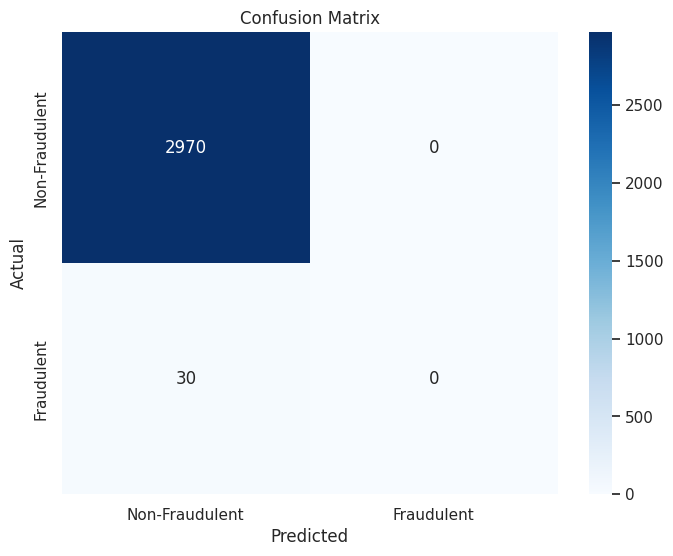

In [22]:
# confusion matrix
cm = confusion_matrix(y_test_raw, y_pred_raw_noimbalance)

# classification report
print("Classification Report:")
print(classification_report(y_test_raw, y_pred_raw_noimbalance))

# Plotting the matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fraudulent', 'Fraudulent'], yticklabels=['Non-Fraudulent', 'Fraudulent'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


### Synthetic Minority Oversampling Technique
- Now we will use SMOTE to see if imbalance handling by synthetic data oversampling is going to help address this class imbalance
- It generates synthetic data and the 1 means that 100% of 0's will be 1.
- For example out of 100 0's 100 will be 1 so total size will be 200 rows

In [23]:
# creating smote model
smote = SMOTE(random_state=42, sampling_strategy=1)
X_train_smote, y_train_smote = smote.fit_resample(X_train_raw, y_train_raw)

# training
log_reg.fit(X_train_smote, y_train_smote)
y_pred_smote = log_reg.predict(X_test_raw)


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [24]:
# checking the new synthetic data
class_counts = Counter(y_train_smote)
print(f"Class distribution after undersampling: {class_counts}")

Class distribution after undersampling: Counter({0.0: 6930, 1.0: 6930})


### Evaluating the model
- We can see that SMOTE model is a little better.
- This shows class imbalance handling is an important value addition.


In [25]:
# evaluation
acc_smote, prec_smote, rec_smote, f1_smote, auc_smote, cm_smote = evaluate_model(y_test_raw, y_pred_smote)

# append to list
results_smote = {
    'Method': 'SMOTE (No Feature Engineering)',
    'Accuracy': acc_smote,
    'Precision': prec_smote,
    'Recall': rec_smote,
    'F1-Score': f1_smote,
    'AUC-ROC': auc_smote
}
results.append(results_smote)
# metrics display
print(f"Accuracy: {acc_smote}")
print(f"Precision: {prec_smote}")
print(f"Recall: {rec_smote}")
print(f"F1-Score: {f1_smote}")
print(f"AUC-ROC: {auc_smote}")

Accuracy: 0.8666666666666667
Precision: 0.018229166666666668
Recall: 0.23333333333333334
F1-Score: 0.033816425120772944
AUC-ROC: 0.5531986531986532


### Synthetic Minority Oversampling Technique Confusion Matrix
- We can see that the tuples that the model predicts as fraud 7 were infact true positives while 377 were false postiives.

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.87      0.93      2970
         1.0       0.02      0.23      0.03        30

    accuracy                           0.87      3000
   macro avg       0.50      0.55      0.48      3000
weighted avg       0.98      0.87      0.92      3000



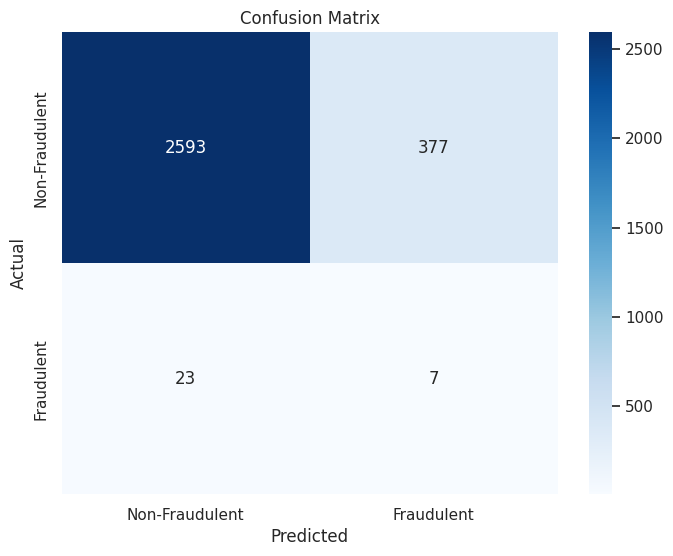

In [26]:

cm = confusion_matrix(y_test_raw, y_pred_smote)

#classification report
print("Classification Report:")
print(classification_report(y_test_raw, y_pred_smote))

# create confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fraudulent', 'Fraudulent'], yticklabels=['Non-Fraudulent', 'Fraudulent'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


### Training undersampling model (automatic undersampling)
- Automatically reduces the major class in a 1 to 1 ratio with the minor class (1) in our case.
- 70:30 split resulted in 70 (0) rows and 70 (1) rows with a train set of 140 rows and 30 rows of test
- No synthetic data is generated here

In [27]:
# automatic undersample with 1:1 ( 1 fraud for 1 non fraud)
undersample = RandomUnderSampler(sampling_strategy=1, random_state=42)
X_train_undersample, y_train_undersample = undersample.fit_resample(X_train_raw, y_train_raw)

# checking the new data
class_counts = Counter(y_train_undersample)
print(f"Class distribution after undersampling: {class_counts}")



Class distribution after undersampling: Counter({0.0: 70, 1.0: 70})


### Predicting and viewing the probabilities of classes
- We can adjust the prediction threshold here if needed

In [28]:
# train model
log_reg.fit(X_train_undersample, y_train_undersample)

# prediction probabilities (Class 1)
y_pred_probabilities = log_reg.predict_proba(X_test_raw)[:, 1]

# Set the threshold (freedom to explore but I did not change this for like to like)
threshold = 0.5

# predictions on adjustment threshold
y_pred_undersample = (y_pred_probabilities >= threshold).astype(int)

# results
print("Prediction Probabilities (Class 1):")
print(y_pred_probabilities)

print("\nAdjusted Predictions (Threshold = {:.2f}):".format(threshold))
print(y_pred_undersample)


Prediction Probabilities (Class 1):
[0.29232648 0.35324338 0.42994263 ... 0.63075296 0.27894725 0.34410529]

Adjusted Predictions (Threshold = 0.50):
[0 0 0 ... 1 0 0]


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Model Evaluation - Undersampling
- It has higher recall but lower f1 than SMOTE

In [29]:
# undersample model evaluation
acc_undersample, prec_undersample, rec_undersample, f1_undersample, auc_undersample, cm_undersample = evaluate_model(y_test_raw, y_pred_undersample)

# append in list and calculate
results_undersample = {
    'Method': 'Automatic Undersampling (No Feature Engineering)',
    'Accuracy': acc_undersample,
    'Precision': prec_undersample,
    'Recall': rec_undersample,
    'F1-Score': f1_undersample,
    'AUC-ROC': auc_undersample
}
results.append(results_undersample)

# results
print(f"\nAutomatic Undersampling Results (No Feature Engineering):")
print(f"Accuracy: {acc_undersample:.4f}")
print(f"Precision: {prec_undersample:.4f}")
print(f"Recall: {rec_undersample:.4f}")
print(f"F1-Score: {f1_undersample:.4f}")
print(f"AUC-ROC: {auc_undersample:.4f}")
print(f"Confusion Matrix: \n{cm_undersample}\n")





Automatic Undersampling Results (No Feature Engineering):
Accuracy: 0.5813
Precision: 0.0040
Recall: 0.1667
F1-Score: 0.0079
AUC-ROC: 0.3761
Confusion Matrix: 
[[1739 1231]
 [  25    5]]



### Undersampling - Automatic - Confusion Matrix
- We can see that the model has predicted 5 true positives with 1231 false positives (an operational cost in this case) while it has predicted 25 false negatives (it does not predict these as frauds)


Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.59      0.73      2970
         1.0       0.00      0.17      0.01        30

    accuracy                           0.58      3000
   macro avg       0.49      0.38      0.37      3000
weighted avg       0.98      0.58      0.73      3000



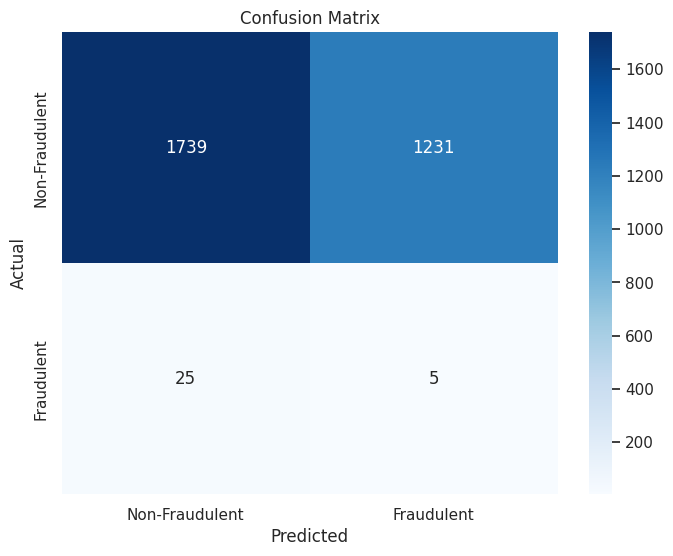

In [30]:
# matrix
cm = confusion_matrix(y_test_raw, y_pred_undersample)

# report
print("Classification Report:")
print(classification_report(y_test_raw, y_pred_undersample))

# output
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fraudulent', 'Fraudulent'], yticklabels=['Non-Fraudulent', 'Fraudulent'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


### Training cost sensitive model
- This model applies a penalty for misclassifying the target class of 1.
- Makes it so that the model becomes cautious of causing errors in the high penalty weight class.
- 100 penalty for wrong in 1 , 1 for 0

In [31]:
# training Manual Cost-Sensitive Learning (Class-Weight Adjustments) on raw data
log_reg_raw = LogisticRegression(class_weight={0: 1, 1: 100}, max_iter=1000)

# fit model
log_reg_raw.fit(X_train_raw, y_train_raw)

# predicting

y_pred_final = log_reg_raw.predict(X_test_raw)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Cost Sensitive Model Evaluation

In [32]:
# Evaluate  Cost-Sensitive Learning (Raw Data)
acc_final, prec_final, rec_final, f1_final, auc_final, cm_final = evaluate_model(y_test_raw, y_pred_final)

# collecting results and appending
results_cost_sensitive = {
    'Method': 'MANUAL Cost-Sensitive Learning (Raw Data)',
    'Accuracy': acc_final,
    'Precision': prec_final,
    'Recall': rec_final,
    'F1-Score': f1_final,
    'AUC-ROC': auc_final
}


results.append(results_cost_sensitive)

#output
print(f"\nCost-Sensitive Learning Results (Raw Data):")
print(f"Accuracy: {acc_final:.4f}")
print(f"Precision: {prec_final:.4f}")
print(f"Recall: {rec_final:.4f}")
print(f"F1-Score: {f1_final:.4f}")
print(f"AUC-ROC: {auc_final:.4f}")
print(f"Confusion Matrix: \n{cm_final}\n")



Cost-Sensitive Learning Results (Raw Data):
Accuracy: 0.6343
Precision: 0.0101
Recall: 0.3667
F1-Score: 0.0197
AUC-ROC: 0.5019
Confusion Matrix: 
[[1892 1078]
 [  19   11]]



### Confusion Matrix - Cost Sensitive Model

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.64      0.78      2970
         1.0       0.01      0.37      0.02        30

    accuracy                           0.63      3000
   macro avg       0.50      0.50      0.40      3000
weighted avg       0.98      0.63      0.77      3000



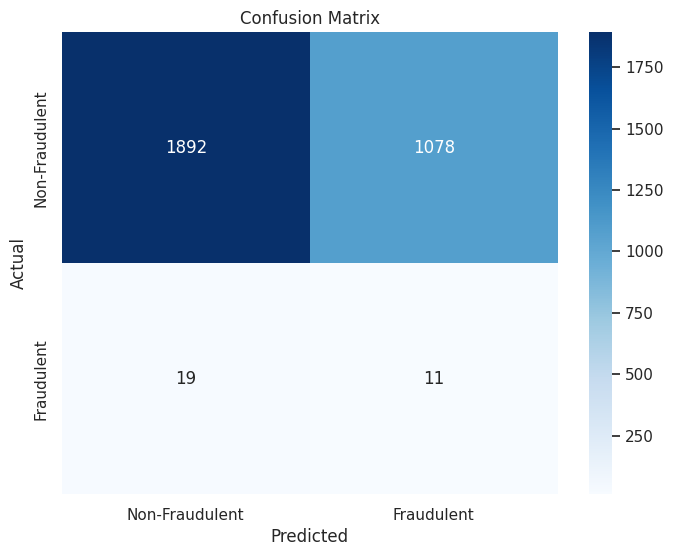

In [33]:
#matrix
cm = confusion_matrix(y_test_raw, y_pred_final)
#report
print("Classification Report:")
print(classification_report(y_test_raw, y_pred_final))

#output
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fraudulent', 'Fraudulent'], yticklabels=['Non-Fraudulent', 'Fraudulent'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


###  Manual Undersampling as per class method
- In our 4th code discussed on 8 March 2025 the undersampling was done by the method below
- We first separate the fraud and non fraud and then merge them as per the length of the fraud (100 in this case) and create a balanced data set
- Then split into train and test (70:30)
- Create a model
- The model is trained on the balanced data set but predicts on the FULL RAW DATA SET for comparability

In [34]:
# separating fraud and non fraud
df_fraud = data_encoded[data_encoded['Fraud'] == 1]
df_non_fraud = data_encoded[data_encoded['Fraud'] == 0]

# Undersample the non-fraud class to match the number of fraud cases
df_non_fraud_sample = df_non_fraud.sample(n=len(df_fraud), random_state=42)

# Combine the fraud and undersampled non-fraud cases
df_balanced = pd.concat([df_fraud, df_non_fraud_sample])

In [35]:
X_balanced = df_balanced.drop(columns=['Fraud', 'FirstPolicySubscriptionDate'])
y_balanced = df_balanced['Fraud']
# definining variables for x and y

In [36]:
# Split data in train and test
X_train_balanced, X_val_balanced, y_train_balanced, y_val_balanced = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)


#### Checking size of the data set

In [37]:
# checking data
print(f"Number of rows and columns in X_train_balanced: {X_train_balanced.shape}")
print(f"Number of rows and columns in Y_train_balanced: {y_train_balanced.shape}")


Number of rows and columns in X_train_balanced: (140, 33)
Number of rows and columns in Y_train_balanced: (140,)


In [38]:
# Train
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_balanced, y_train_balanced)

# predict on full raw set
y_pred_balanced = log_reg.predict(X_train_raw)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


###  Class Undersample Model Evaluation
This model has good recall but at the expense of false positives,

In [39]:
# model evaluation
acc_balanced, prec_balanced, rec_balanced, f1_balanced, auc_balanced, cm_balanced = evaluate_model(y_train_raw, y_pred_balanced)

# matrix
print(f"Confusion Matrix:\n{cm_balanced}\n")

# report
print("Classification Report:")
print(classification_report(y_train_raw, y_pred_balanced))

# collecting result and appending
results_balanced = {
    'Method': 'Undersampling - Class Method FULL DATA',
    'Accuracy': acc_balanced,
    'Precision': prec_balanced,
    'Recall': rec_balanced,
    'F1-Score': f1_balanced,
    'AUC-ROC': auc_balanced
}

results.append(results_balanced)

Confusion Matrix:
[[3670 3260]
 [  30   40]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.53      0.69      6930
         1.0       0.01      0.57      0.02        70

    accuracy                           0.53      7000
   macro avg       0.50      0.55      0.36      7000
weighted avg       0.98      0.53      0.68      7000



### Class Undersample Model Confusion Matrix

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.53      0.69      6930
         1.0       0.01      0.57      0.02        70

    accuracy                           0.53      7000
   macro avg       0.50      0.55      0.36      7000
weighted avg       0.98      0.53      0.68      7000



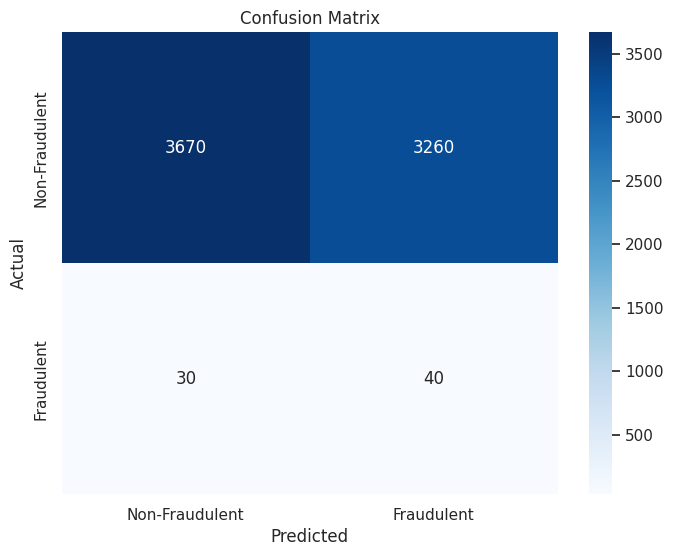

In [40]:
cm = cm_balanced
print("Classification Report:")
print(classification_report(y_train_raw, y_pred_balanced))

# matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fraudulent', 'Fraudulent'], yticklabels=['Non-Fraudulent', 'Fraudulent'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


## Feature Engineering (AI Assisted Content)

- Data was reloaded to ensure no corruption

| **Feature Name**                     | **Description** |
|--------------------------------------|----------------|
| **ClaimAgeRatio** | Compares the policyholder's age to the vehicle's age. |
| **ClaimAmountPerPolicy** | Shows how much claim amount is being made per policy owned by the policyholder. |
| **DamageImportanceToClaimAmountRatio** | Measures the reported damage importance relative to the claim amount. Higher values may suggest exaggerated claims. |
| **PolicySubscriptionDuration** | Calculates how long the policy has been active in days. Older policies may have different fraud patterns. |
| **TimeBetweenClaims** | Measures the gap (in days) between successive claims on the same vehicle. Frequent claims might indicate fraud. |
| **ClaimFrequency** | Compares the number of policies to the claim amount. Higher values might indicate suspiciously frequent claims. |
| **ClaimWithoutThirdPartyRatio** | Measures the proportion of claims that were reported without an identified third party, which could indicate staged accidents. |
| **PolicyholderRisk** | A rough risk score based on the policyholder’s age and the number of policies they hold. |
| **ClaimAmountPerBodilyInjury** | Shows how much claim amount is being made per reported bodily injury. Unusually high values could indicate exaggerated injuries. |
| **ClaimHourBinned** | Groups the time of loss into four categories (Night, Morning, Afternoon, Evening) to analyze fraud patterns at different times of the day. |
| **ClaimAmountCategorical** | Divides claim amounts into Low, Medium, High, and Very High categories for better pattern analysis. |
| **OldVehicleFlag** | Flags whether the vehicle is older than 10 years. Older vehicles might be linked to more fraudulent claims. |
| **HighClaimAmountFlag** | Identifies the top 25% of claims based on amount. Higher-value claims are often more scrutinized for fraud. |
| **WeekendOrHolidayLoss** | Marks whether the loss happened on a weekend or public holiday. Fraud might be more likely when fewer witnesses are around. |
| **LossAtOddHours** | Flags claims that happened between midnight and 4 AM, which could indicate staged accidents. |
| **PolicyTenureCategory** | Categorizes how long the policy has been active: New, 1-3 Years, or 3+ Years. Newer policies might have different fraud risks. |
| **PolicyAgeGroup** | Categorizes policyholders as Young, Middle-aged, or Senior to study fraud patterns across different age groups. |


In [41]:
# loading again to avoid corruption
file_path = "insurance_claims.csv"
df = pd.read_csv(file_path)

# Convert date columns to datetime
df['FirstPolicySubscriptionDate'] = pd.to_datetime(df['FirstPolicySubscriptionDate'])
df['LossDate'] = pd.to_datetime(df['LossDate'])

# Feature 1: ClaimAgeRatio - Policyholder age relative to vehicle age
df['ClaimAgeRatio'] = df['PolicyHolderAge'] / (df['FpVehicleAgeMonths'] + 1)

# Feature 2: ClaimAmountPerPolicy - Claim amount divided by number of policies
df['ClaimAmountPerPolicy'] = df['ClaimAmount'] / (df['NumberOfPoliciesOfPolicyholder'] + 1)

# Feature 3: DamageImportanceToClaimAmountRatio
df['DamageImportanceToClaimAmountRatio'] = df['DamageImportance'] / (df['ClaimAmount'] + 1)

# Feature 4: PolicySubscriptionDuration - Number of days since policy subscription
df['PolicySubscriptionDuration'] = (pd.to_datetime('today') - df['FirstPolicySubscriptionDate']).dt.days

# Feature 5: TimeBetweenClaims - Days between claims for the same vehicle
df['TimeBetweenClaims'] = df.groupby(['FirstPartyVehicleNumber', 'FirstPartyVehicleType'])['LossDate'].diff().dt.days.abs()
df['TimeBetweenClaims'] = df['TimeBetweenClaims'].fillna(0)

# Feature 6: ClaimFrequency - Number of policies per claim
df['ClaimFrequency'] = df['NumberOfPoliciesOfPolicyholder'] / (df['ClaimAmount'] + 1)

# Feature 7: ClaimWithoutThirdPartyRatio - Ratio of self-reported claims
df['ClaimWithoutThirdPartyRatio'] = df['ClaimWithoutIdentifiedThirdParty'] / (df['ClaimAmount'] + 1)

# Feature 8: PolicyholderRisk - Combined risk metric
df['PolicyholderRisk'] = df['PolicyHolderAge'] * (df['NumberOfPoliciesOfPolicyholder'] + 1)

# Feature 9: ClaimAmountPerBodilyInjury - Claim amount per injury
df['ClaimAmountPerBodilyInjury'] = df['ClaimAmount'] / (df['NumberOfBodilyInjuries'] + 1)

# Feature 10: ClaimHourBinned - Categorize loss hour
bins = [0, 6, 12, 18, 24]
labels = ['Night', 'Morning', 'Afternoon', 'Evening']
df['ClaimHourBinned'] = pd.cut(df['LossHour'], bins=bins, labels=labels, right=False)

# Feature 11: ClaimAmountCategorical - Categorize claim amounts
bins = [0, 5000, 20000, 50000, np.inf]
labels = ['Low', 'Medium', 'High', 'Very High']
df['ClaimAmountCategorical'] = pd.cut(df['ClaimAmount'], bins=bins, labels=labels)

# Feature 12: OldVehicleFlag - If vehicle age >10 years
df['OldVehicleFlag'] = df['FpVehicleAgeMonths'] / 12 > 10

# Feature 13: HighClaimAmountFlag - Top 25% of claims
df['HighClaimAmountFlag'] = df['ClaimAmount'] > df['ClaimAmount'].quantile(0.75)

# Feature 14: WeekendOrHolidayLoss - If claim occurred on weekend/public holiday
df['WeekendOrHolidayLoss'] = df['LossDate'].dt.dayofweek >= 5

# Feature 15: LossAtOddHours - If loss happened between 12 AM - 4 AM
df['LossAtOddHours'] = df['LossHour'].between(0, 4)

# Feature 16: PolicyTenureCategory - Categorizing policy tenure
df['PolicyTenureCategory'] = pd.cut(df['PolicySubscriptionDuration'],
                                    bins=[-1, 365, 1095, float('inf')],
                                    labels=['New', '1-3 Years', '3+ Years'])

# Feature 17: PolicyAgeGroup - Categorizing policyholder age
df['PolicyAgeGroup'] = pd.cut(df['PolicyHolderAge'], bins=[-1, 30, 50, float('inf')],
                              labels=['Young', 'Middle-aged', 'Senior'])

# Drop redundant columns
columns_to_drop = [
    'EasinessToStage', 'NumberOfBodilyInjuries', 'ClaimAmount', 'LossHour',
    'FpVehicleAgeMonths', 'NumberOfPoliciesOfPolicyholder', 'PolicyHolderAge',
    'FirstPolicySubscriptionDate', 'LossDate'
]
df_cleaned = df.drop(columns=columns_to_drop)

# Show dataset info after feature engineering
df_cleaned.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 34 columns):
 #   Column                              Non-Null Count  Dtype   
---  ------                              --------------  -----   
 0   PolicyholderNumber                  10000 non-null  object  
 1   FirstPartyVehicleNumber             10000 non-null  object  
 2   PolicyholderOccupation              10000 non-null  object  
 3   FirstPartyVehicleType               10000 non-null  object  
 4   PolicyholderPostCode                10000 non-null  int64   
 5   PolicyWasSubscribedOnInternet       10000 non-null  int64   
 6   FirstPartyLiability                 10000 non-null  float64 
 7   ReferenceId                         10000 non-null  object  
 8   ThirdPartyVehicleNumber             10000 non-null  object  
 9   InsurerNotes                        10000 non-null  object  
 10  ClaimCause                          10000 non-null  object  
 11  ClaimInvolvedCovers          

### Checking missing values in these new fetures

In [42]:
# Check for missing values
missing_values = df.isnull().sum()

# Print the result
print("Missing Values in Each Column:\n", missing_values)


Missing Values in Each Column:
 PolicyholderNumber                    0
FirstPartyVehicleNumber               0
PolicyholderOccupation                0
FirstPolicySubscriptionDate           0
FirstPartyVehicleType                 0
PolicyholderPostCode                  0
PolicyWasSubscribedOnInternet         0
NumberOfPoliciesOfPolicyholder        0
FpVehicleAgeMonths                    0
PolicyHolderAge                       0
FirstPartyLiability                   0
ReferenceId                           0
ThirdPartyVehicleNumber               0
InsurerNotes                          0
LossDate                              0
ClaimCause                            0
ClaimInvolvedCovers                   0
DamageImportance                      0
ConnectionBetweenParties              0
LossPostCode                          0
EasinessToStage                       0
ClaimWithoutIdentifiedThirdParty      0
ClaimAmount                           0
LossHour                              0
NumberOf

### Checking cardinality to decide which columns to drop and encode

In [43]:
# checking cardinality
categorical_columns = df_cleaned.select_dtypes(include=['object']).columns

# catagorical cols
cardinality = df_cleaned[categorical_columns].nunique()
print(cardinality)

PolicyholderNumber          10000
FirstPartyVehicleNumber      9467
PolicyholderOccupation          6
FirstPartyVehicleType           5
ReferenceId                 10000
ThirdPartyVehicleNumber      9451
InsurerNotes                    4
ClaimCause                      5
ClaimInvolvedCovers             4
ConnectionBetweenParties        2
dtype: int64


In [44]:
# bring clean back to df
df = df_cleaned

# drop irrelevant columns which are highly unique values
drop_columns = [
                'FirstPartyVehicleNumber', 'ThirdPartyVehicleNumber','PolicyholderNumber','ReferenceId']
df = df.drop(columns=drop_columns)

# Convert 'ConnectionBetweenParties' column yes no to 1 0
df['ConnectionBetweenParties'] = df['ConnectionBetweenParties'].apply(lambda x: 1 if x == 'Yes' else 0)

# One-hot encode
variables_to_encode = [
    'PolicyholderOccupation', 'ClaimInvolvedCovers', 'FirstPartyVehicleType',
    'InsurerNotes', 'ClaimCause','PolicyAgeGroup','PolicyTenureCategory','ClaimAmountCategorical','ClaimHourBinned'
]

df_encoded = pd.get_dummies(df, columns=variables_to_encode, drop_first=True, dtype=int)


###Checking if anything else needs to be converted after encoding

In [45]:
print(df_encoded.dtypes)  # checking data types

for col in df_encoded.select_dtypes(include=['object']).columns:
    print(f"Unique values in {col}:\n", df_encoded[col].unique(), "\n")


PolicyholderPostCode                    int64
PolicyWasSubscribedOnInternet           int64
FirstPartyLiability                   float64
DamageImportance                        int64
ConnectionBetweenParties                int64
LossPostCode                            int64
ClaimWithoutIdentifiedThirdParty        int64
Fraud                                 float64
ClaimAgeRatio                         float64
ClaimAmountPerPolicy                  float64
DamageImportanceToClaimAmountRatio    float64
PolicySubscriptionDuration              int64
TimeBetweenClaims                     float64
ClaimFrequency                        float64
ClaimWithoutThirdPartyRatio           float64
PolicyholderRisk                        int64
ClaimAmountPerBodilyInjury            float64
OldVehicleFlag                           bool
HighClaimAmountFlag                      bool
WeekendOrHolidayLoss                     bool
LossAtOddHours                           bool
PolicyholderOccupation_Doctor     

In [46]:
df_encoded

,PolicyholderPostCode,PolicyWasSubscribedOnInternet,FirstPartyLiability,DamageImportance,ConnectionBetweenParties,LossPostCode,ClaimWithoutIdentifiedThirdParty,Fraud,ClaimAgeRatio,ClaimAmountPerPolicy,...,PolicyAgeGroup_Middle-aged,PolicyAgeGroup_Senior,PolicyTenureCategory_1-3 Years,PolicyTenureCategory_3+ Years,ClaimAmountCategorical_Medium,ClaimAmountCategorical_High,ClaimAmountCategorical_Very High,ClaimHourBinned_Morning,ClaimHourBinned_Afternoon,ClaimHourBinned_Evening
0,75165,0,0.121587,5,0,81328,0,0.0,0.402597,12415.591620,...,1,0,0,1,0,1,0,0,1,0
1,45809,1,0.612870,8,0,88724,0,0.0,0.683673,16462.785837,...,0,1,0,1,0,1,0,0,0,1
2,42165,0,0.871980,1,0,68441,0,0.0,0.429379,2908.991978,...,0,1,0,1,1,0,0,0,0,1
3,82232,0,0.500794,9,0,44767,0,0.0,0.467105,24349.026569,...,0,1,0,1,0,1,0,0,0,1
4,85642,0,0.771998,8,0,46852,0,0.0,0.341463,19333.346966,...,0,0,0,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,80283,1,0.745130,7,0,16775,0,0.0,0.195455,1766.420780,...,1,0,0,1,1,0,0,1,0,0
9996,73266,0,0.553707,7,0,34755,0,0.0,0.076596,3663.879018,...,0,0,0,1,1,0,0,0,0,1
9997,41869,0,0.388769,8,0,60380,1,0.0,0.373494,13001.729838,...,1,0,0,1,0,1,0,0,1,0
9998,84349,0,0.877165,2,0,17804,0,0.0,0.440000,16153.425534,...,0,0,0,1,0,1,0,0,0,1


### Spliting the encoded data set into train and test using 70:30
- 70 30 used as imbalanced




In [47]:
X_encoded = df_encoded.drop(columns=['Fraud'])  # Drop target column 'Fraud' so unseen
y_encoded = df_encoded['Fraud']  # Target column

# Stratified train-test split to maintain class balance in both sets
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(
    X_encoded, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)


### Printing the sizes
- We can see that the number of features (columns) has increased from 33 to 49 (33 was due to encoding)

In [48]:
# Print the size of each split
print(f"Size of X_train: {X_train_final.shape}")
print(f"Size of X_test: {X_test_final.shape}")
print(f"Size of y_train: {y_train_final.shape}")
print(f"Size of y_test: {y_test_final.shape}")

Size of X_train: (7000, 49)
Size of X_test: (3000, 49)
Size of y_train: (7000,)
Size of y_test: (3000,)


### Repeating the class undersampling method

In [49]:
#  undersampling to balance the dataset
df_fraud = df_encoded[df_encoded['Fraud'] == 1]
df_non_fraud = df_encoded[df_encoded['Fraud'] == 0]
df_non_fraud_sample = df_non_fraud.sample(n=len(df_fraud), random_state=42)
df_balanced = pd.concat([df_fraud, df_non_fraud_sample])

In [50]:
# defining x and y and making sure model doesnt see fraud
X_balanced = df_balanced.drop(columns=['Fraud'])
y_balanced = df_balanced['Fraud']

In [51]:
# Train-test split (70-30)
X_train_bal_featured, X_test_bal_featured, y_train_bal_featured, y_test_bal_featured = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42, stratify=y_balanced)
X_train_balanced_featured = X_train_bal_featured
X_test_balanced_featured = X_test_bal_featured

In [52]:
# Print the size of each split
print(f"Size of X_train: {X_train_bal_featured.shape}")
print(f"Size of X_test: {X_test_bal_featured.shape}")
print(f"Size of y_train: {y_train_bal_featured.shape}")
print(f"Size of y_test: {y_test_bal_featured.shape}")

Size of X_train: (140, 49)
Size of X_test: (60, 49)
Size of y_train: (140,)
Size of y_test: (60,)


###  Training  Class method Undersampling Model

In [53]:
# Train logistic regression model
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_balanced_featured, y_train_bal_featured)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000)

###  Predictions
- We predict on both the full data and the undersampled data of 40 rows

In [54]:
# Predictions
y_pred_bal_featured = log_reg.predict(X_test_bal_featured)
y_prob_bal_featured = log_reg.predict_proba(X_test_balanced_featured)[:, 1]
y_pred_bal_featured_fulldata = log_reg.predict(X_test_final)
y_prob_bal_featured_fulldata = log_reg.predict_proba(X_test_final)[:, 1]

In [55]:
# Initialize the model and list to store results
log_reg_final = LogisticRegression(max_iter=1000)
methods = [
    'No Class Imbalance but with Feature Engineering',
    'SMOTE (Feature Engineering)',
    'Automatic Undersampling (Feature Engineering)',
    'Undersampling - Class Method (Reference Nibaf Ecommerce Fraud - Feature Engineering)',
    'Class-Weight Adjustments (Feature Engineering)',
    'MANUAL Cost-Sensitive Learning (Feature Engineering)'
]


### Master Code for looping through all the models on the new feature engineered data
- Code calculates the metrics using the eval function defined earlier
- Code then merges all into results
- Then works on the manually trained model earlier in the previous cells and merges it


In [56]:
# Dictionary to store confusion matrices & predictions
conf_matrices = {}
model_predictions = {}

# Loop through all methods
for best_method in methods:

    if best_method == 'SMOTE (Feature Engineering)':
        smote = SMOTE(random_state=42, sampling_strategy=0.55)
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train_final, y_train_final)

    elif best_method == 'Automatic Undersampling (Feature Engineering)':
        undersample = RandomUnderSampler(random_state=42)
        X_train_resampled, y_train_resampled = undersample.fit_resample(X_train_final, y_train_final)

    elif best_method == 'MANUAL Cost-Sensitive Learning (Feature Engineering)':
        log_reg_final = LogisticRegression(class_weight={0: 1, 1: 100}, max_iter=1000)
        X_train_resampled, y_train_resampled = X_train_final, y_train_final  # No resampling

    elif best_method == 'No Class Imbalance but with Feature Engineering':
        X_train_resampled, y_train_resampled = X_train_final, y_train_final  # No resampling
        log_reg_final = LogisticRegression(max_iter=1000)  # Standard logistic regression

    else:
        continue  # we want to skip model training for 'Undersampling - Class Method' as we already trained it above

    # Train the model
    log_reg_final.fit(X_train_resampled, y_train_resampled)

    # Make predictions
    y_pred = log_reg_final.predict(X_test_final)

    # Store predictions and confusion matrix
    model_predictions[best_method] = y_pred
    conf_matrices[best_method] = confusion_matrix(y_test_final, y_pred)

    # Evaluate model
    acc, prec, rec, f1, auc, cm = evaluate_model(y_test_final, y_pred)

    # Store results for comparison
    results.append({
        'Method': best_method,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1,
        'AUC-ROC': auc
    })

# merging the already trained model
method_name = 'Undersampling - Class Method (Reference Nibaf Ecommerce Fraud - Feature Engineering)'

# Use stored predictions and test data
acc, prec, rec, f1, auc, cm = evaluate_model(y_test_bal_featured, y_pred_bal_featured)

# Store confusion matrix
conf_matrices[method_name] = cm

# Store results for comparison
results.append({
    'Method': method_name,
    'Accuracy': acc,
    'Precision': prec,
    'Recall': rec,
    'F1-Score': f1,
    'AUC-ROC': auc
})


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

### Merging using the metrics on full data of the undersample model

In [57]:
#adding the full data model (reused the code above)
method_name = 'Undersampling FULL DATA - Class Method (Reference Nibaf Ecommerce Fraud - Feature Engineering)'

# Use stored predictions and test data
acc, prec, rec, f1, auc, cm = evaluate_model(y_test_final, y_pred_bal_featured_fulldata)

# Store confusion matrix
conf_matrices[method_name] = cm

# Store results for comparison
results.append({
    'Method': method_name,
    'Accuracy': acc,
    'Precision': prec,
    'Recall': rec,
    'F1-Score': f1,
    'AUC-ROC': auc
})


# Model Evaluation (3 Marks)
- Confusion Matrix Analysis
- Model Performance and metrics Analysis (table below)

## Confusion Matrix Analysis

For the analysis below:
- FP means false positives which means that the model incorrectly predicts fraud when in reality it was not fraud .
- FN means false negatives which means that the model incorrectly predicts that there is no fraud when in reality it was fraud.
- Both FP and FN are a trade off.

## No Class Imbalance but with Feature Engineering

- FP: 0
- FN: 30
- Explanation: The model completely ignores fraudulent cases, classifying all as non-fraudulent. This means that the model is unable to predict any fraud cases

## SMOTE (Feature Engineering)

- FP: 92
- FN: 29
- Explanation: Improves recall slightly from without class imbalance model but it is still struggling to correctly classify fraudulent cases.

## Automatic Undersampling (Feature Engineering)

- FP: 1312
- FN: 18
- Explanation: This model trades off high false positives for better fraud detection. If the threshold is increased then there is a potential for improvement.

## Manual Cost-Sensitive Learning (Feature Engineering)

- FP: 1067
- FN: 18
- Explanation: This model is similar to the model above as it is having the same false negatives but lower false positives. Between the two this is the better model.

## Undersampling - Class Method (Reference Nibaf Ecommerce Fraud - Feature Engineering)

- FP: 15
- FN: 13
- Explanation: This is just to illustrate that the best model was trained on an undersampled data set and on that its performance was quite balanced.

## Undersampling FULL DATA - Class Method (Reference Nibaf Ecommerce Fraud - Feature Engineering)

- FP: 1533
- FN: 10
- Explanation: The best model predicts fraud good but it is too strict and produces a lot of false positives (misclassifies non fraud cases).

## Combined plots of Confusion Matrixes

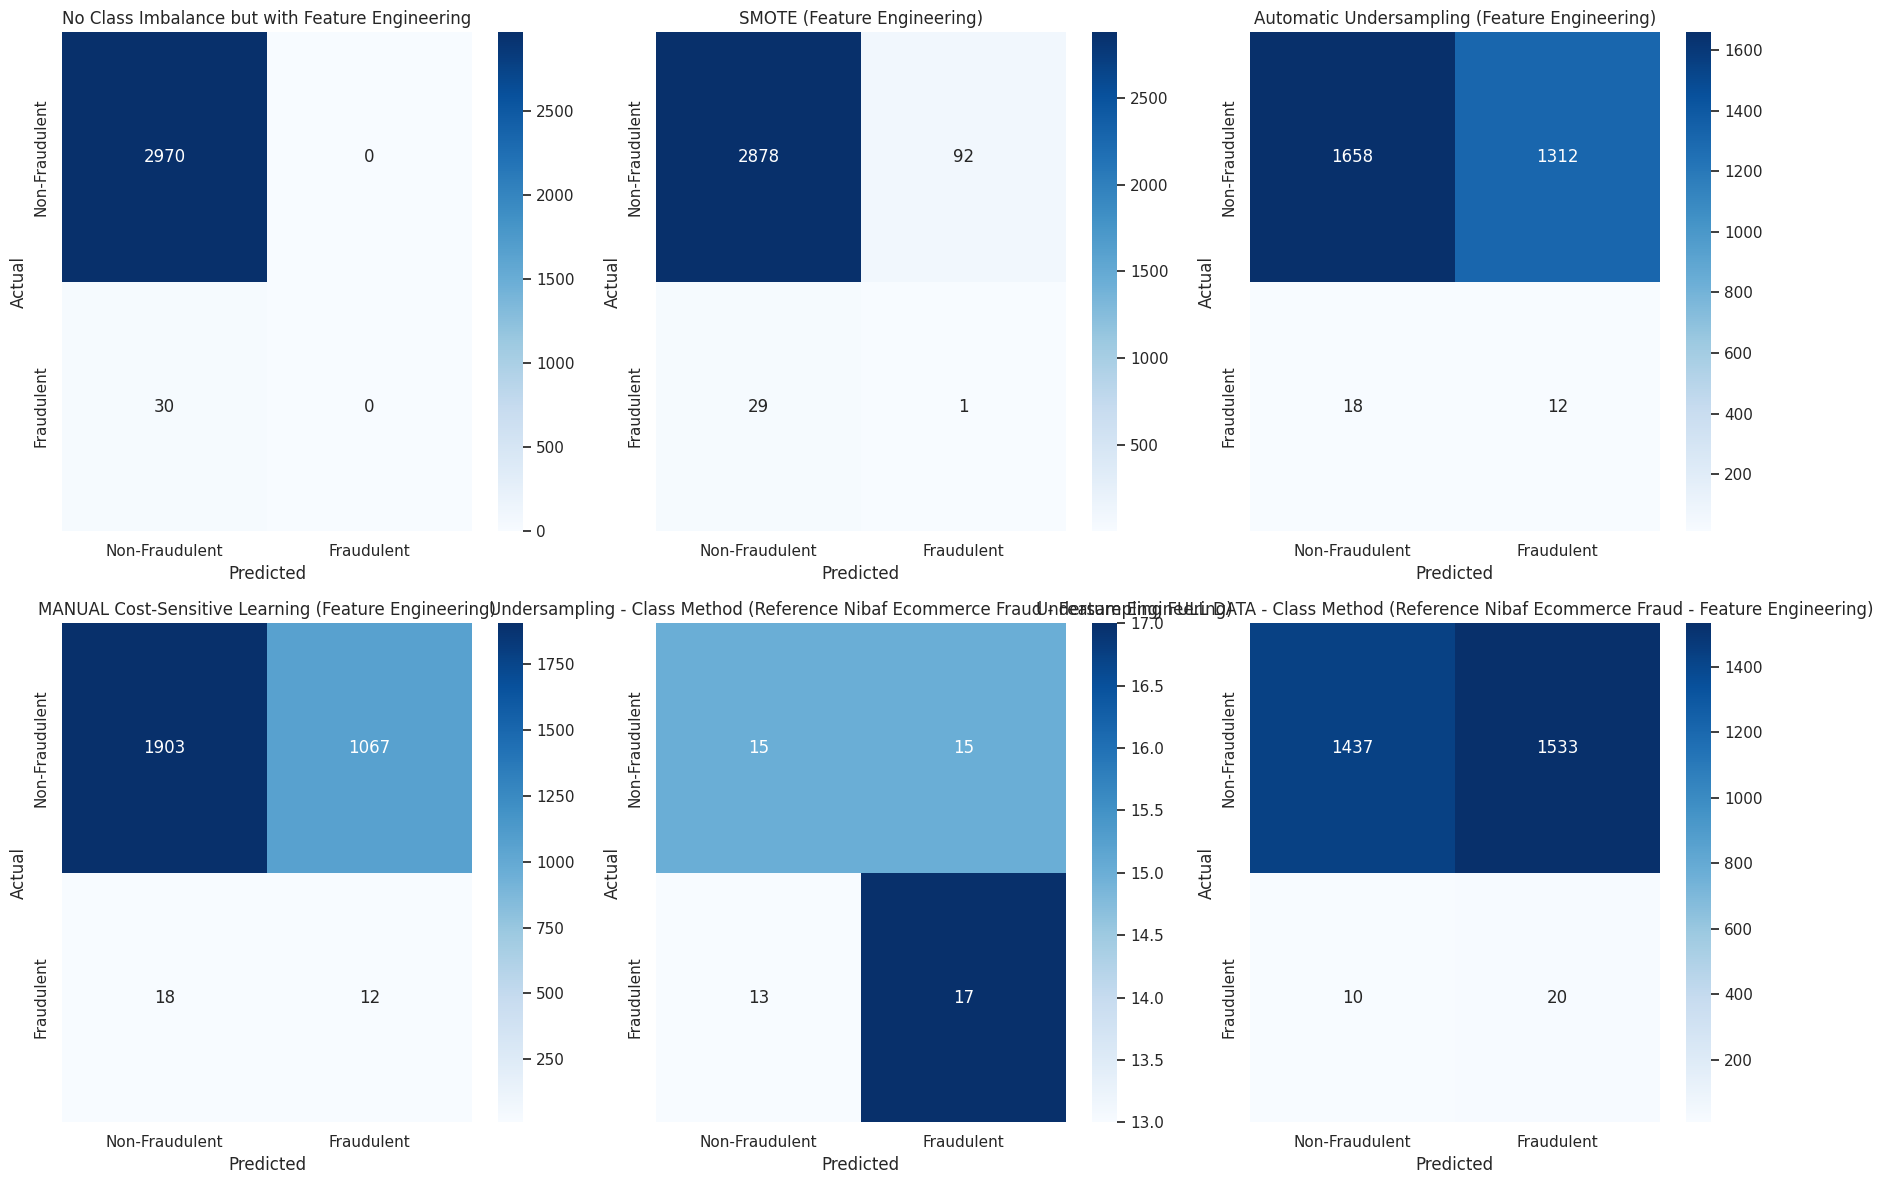

In [58]:
num_methods = len(conf_matrices)  # Total number of models
num_cols = 3  # Keep 3 columns for better visualization
num_rows = math.ceil(num_methods / num_cols)  # Dynamically adjust rows

fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 6 * num_rows))
axes = axes.flatten()  # Flatten for easier indexing

for i, (method, cm) in enumerate(conf_matrices.items()):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fraudulent', 'Fraudulent'],
                yticklabels=['Non-Fraudulent', 'Fraudulent'], ax=axes[i])
    axes[i].set_title(method)
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


## Analysis of Table
### For the purpose of this analysis
- Precision means when fraud was predicted how accurate it was.
- Recall means how many of actual fraud cases where identified by the model.
- f1 is harmonic mean of precision and recall. Used as a decision criteria to select models.
- AUC-ROC is the model's ability to distinguish between classes at different thresholds. Higher the better.


---


- We can see from the table below that Class imbalance is extremely important to be able to predict fraud as Model 0 and Model 5 are unable to recall any fraud cases even with feature engineering. However, this model has the highest accuracy (99%) but it is irrelevant to us as we do not want to rely on this metric.
- SMOTE provides improvement in recall but at the expense of accuracy but it is not the best model. Moreover, surprisingly with feature engineering the model performance drops , this is attributable to the increase in features.
- The automatic undersampling sees a sharp decline in accuracy as the rows are sampled and not all rows are visible to the model (major class downsized) so the model looses accuracy. However, it has good increase in recall with feature engineering.
- Manual cost sensitive learning model has better accuracy than automatic and has similar recall with better f1 score
- However, the best model is undersampling which has the best recall 67% and the highest f1 score of 2.5%. It has quity low accuracy but as explained this is because it has not seen a lot of data and was  trained on a subset.

### Conclusive Summary
- Class Imbalance significantly improves recall (needed for predicting fraud in imbalanced data)
- Feature engineering improves recall and f1 score
- Feature engineering alone is not a substitute for class imbalance.

In [59]:
# Convert results to a DataFrame for easy comparison
results_df = pd.DataFrame(results)
results_df

,Method,Accuracy,Precision,Recall,F1-Score,AUC-ROC
0,No Class Imbalance (No Feature Engineering),0.990000,0.000000,0.000000,0.000000,0.500000
1,SMOTE (No Feature Engineering),0.866667,0.018229,0.233333,0.033816,0.553199
2,Automatic Undersampling (No Feature Engineering),0.581333,0.004045,0.166667,0.007899,0.376094
3,MANUAL Cost-Sensitive Learning (Raw Data),0.634333,0.010101,0.366667,0.019660,0.501852
4,Undersampling - Class Method FULL DATA,0.530000,0.012121,0.571429,0.023739,0.550505
5,No Class Imbalance but with Feature Engineering,0.990000,0.000000,0.000000,0.000000,0.500000
6,SMOTE (Feature Engineering),0.959667,0.010753,0.033333,0.016260,0.501178
7,Automatic Undersampling (Feature Engineering),0.556667,0.009063,0.400000,0.017725,0.479125
8,MANUAL Cost-Sensitive Learning (Feature Engine...,0.638333,0.011121,0.400000,0.021641,0.520370
9,Undersampling - Class Method (Reference Nibaf ...,0.533333,0.531250,0.566667,0.548387,0.533333


## Selecting the best model based on F1-Score

In [60]:
# Selecting the best method based on F1-Score
best_row = results_df.loc[results_df['F1-Score'].idxmax()]

# Extract values
best_method = best_row['Method']
best_accuracy = best_row['Accuracy']
best_precision = best_row['Precision']
best_recall = best_row['Recall']
best_f1 = best_row['F1-Score']
best_auc = best_row['AUC-ROC']

# Print the best method and its performance indicators
print(f"Best Method for Handling Class Imbalance: {best_method}")
print(f"Accuracy: {best_accuracy:.4f}")
print(f"Precision: {best_precision:.4f}")
print(f"Recall: {best_recall:.4f}")
print(f"F1-Score: {best_f1:.4f}")
print(f"AUC-ROC: {best_auc:.4f}")


Best Method for Handling Class Imbalance: Undersampling - Class Method (Reference Nibaf Ecommerce Fraud - Feature Engineering)
Accuracy: 0.5333
Precision: 0.5312
Recall: 0.5667
F1-Score: 0.5484
AUC-ROC: 0.5333


## INVESTIGATING POTENTIAL DATA LEAKAGE
- There appears to be no variable with data leakage as all are low correlated with fraud.
- However we can use this matrix as a basis to opt for regularization
- We can see that there are very few correlated features with Fraud
- We will now conduct lasso l1 regularization below to remove these irrelevant features from our best model selected above

Top features correlated with Fraud:
 PolicyholderOccupation_Lawyer    0.030670
FirstPartyVehicleType_SUV        0.028022
InsurerNotes_Total loss          0.019529
WeekendOrHolidayLoss             0.017728
ClaimCause_Fire                  0.015480
ClaimAmountCategorical_Medium    0.013743
FirstPartyLiability              0.013143
ClaimInvolvedCovers_Liability    0.011217
ConnectionBetweenParties         0.008824
ClaimHourBinned_Morning          0.008047
Name: Fraud, dtype: float64


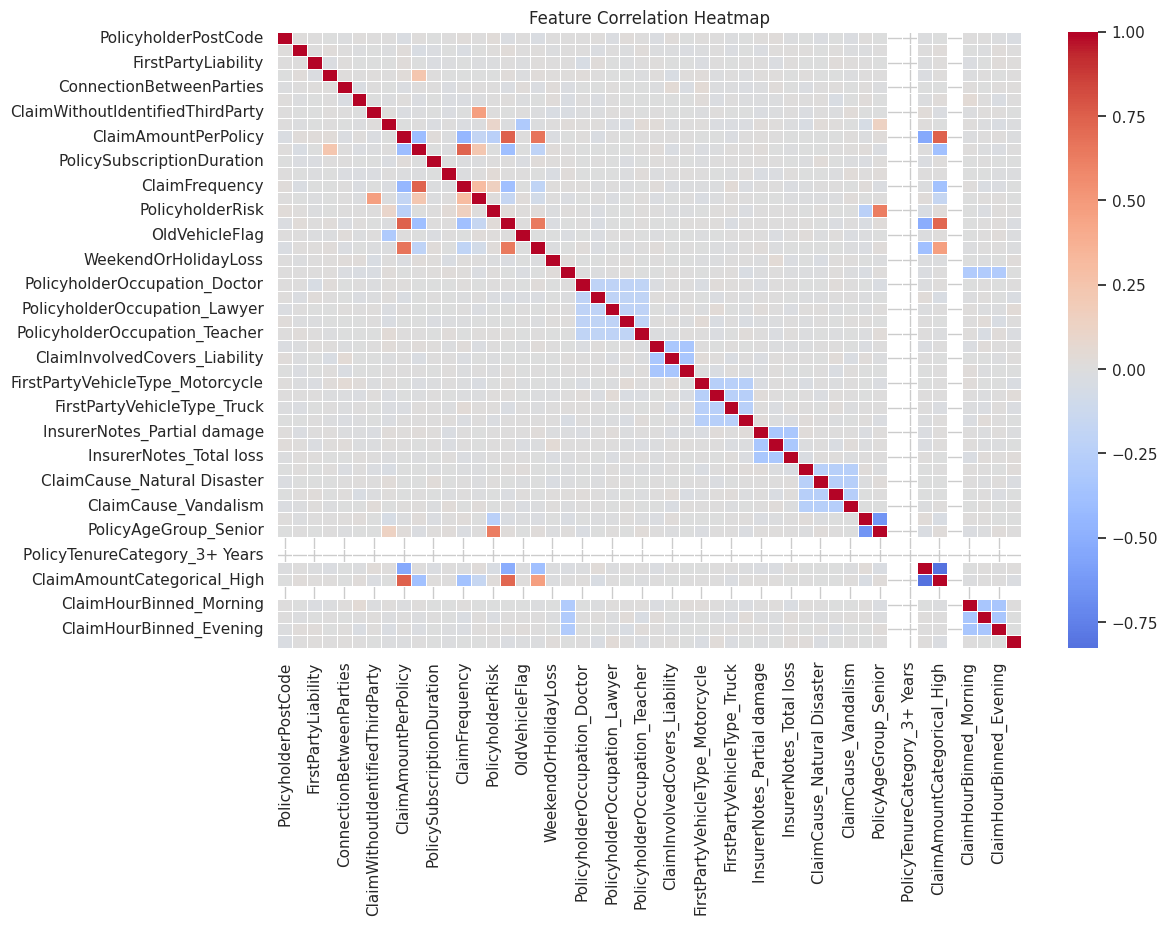

In [61]:
# Combine Features and Target for correlation analysis
full_data = pd.concat([X_train_final, y_train_final], axis=1)

# Compute correlation matrix
corr_matrix = full_data.corr()

# Sort correlations with the target variable (Fraud)
target_corr = corr_matrix[y_train_final.name].drop(y_train_final.name).sort_values(ascending=False)

# Print top correlated features
print("Top features correlated with Fraud:\n", target_corr.head(10))

# Plot heatmap for correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', linewidths=0.5, center=0)
plt.title("Feature Correlation Heatmap")
plt.show()


## Regularization of L1 to remove irrelevant features as per above
- The model is trained below
- The confusion metric, roc and auc curves are plotted

In [62]:
# Train logistic regression model with L1 regularization
log_reg = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000)
log_reg.fit(X_train_balanced_featured, y_train_bal_featured)

# Make predictions on the test data
y_pred = log_reg.predict(X_test_final)



## Analysis of regularized model
- We can see that the model recall improves to 70% at the expense of false positives
- The model AUC is around 59% (close to 60%) which means that it is only ~ 10% better than a random guessing model at distinguishing between classes.
- This problem is happening due to the severe imbalance in data.
- However, lasso regularization does improve our best model's AUC
- False positives increase but False Negatives decrease (tradeoff) compared to non regularized model ( 1543 false positives by l1 vs 1533 by non l1 AND 9 false negatives by l1 vs 10 false negatives by non l1)

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.48      0.65      2970
         1.0       0.01      0.70      0.03        30

    accuracy                           0.48      3000
   macro avg       0.50      0.59      0.34      3000
weighted avg       0.98      0.48      0.64      3000



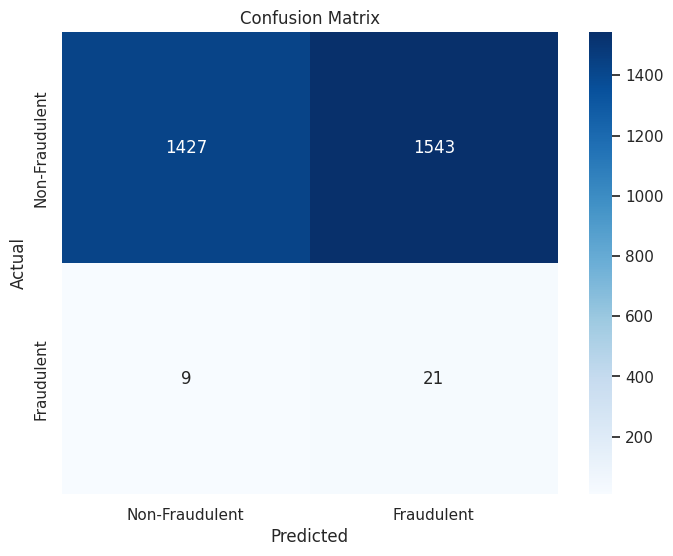

AUC-ROC Score: 0.5979


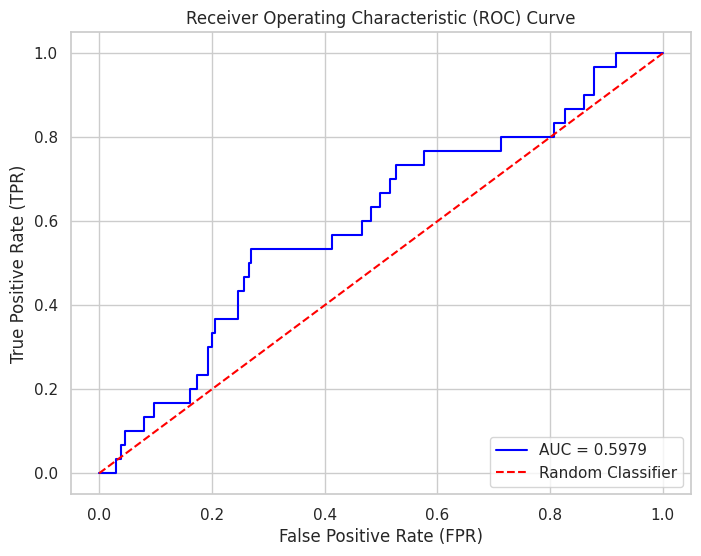

In [63]:
# Generate the confusion matrix
cm = confusion_matrix(y_test_final, y_pred)

# Print the classification report
print("Classification Report:")
print(classification_report(y_test_final, y_pred))

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Fraudulent', 'Fraudulent'],
            yticklabels=['Non-Fraudulent', 'Fraudulent'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Calculate the AUC-ROC score
y_pred_prob = log_reg.predict_proba(X_test_final)[:, 1]  # GETTING PROBABILITIES ONLY FOR THE POSITIVE CLASS HERE
auc = roc_auc_score(y_test_final, y_pred_prob)
print(f"AUC-ROC Score: {auc:.4f}")

# Plot the AUC-ROC curve
fpr, tpr, thresholds = roc_curve(y_test_final, y_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'AUC = {auc:.4f}')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

# Insights and Recommendations (2 Marks)


## Summary of Model Performance and Strengths (Discussed earlier)
- The best model was undersampling by creating balanced data sets manually as taught in class.
- This model initially had an AUC of 57.5% so it was only 7.5% better than a random guesser at distinguishing between classes.
- This model had the best in class performance with respect to recall being 66.67% and f1 being 2.5%
- This best model was further improved by lasso l1 regularization as there were many irrelevant features.
- The best model now has a respectable 59.7% AUC and 0.03 f1 score with 70% recall.
- The model has the key strength of being able to identify fraud cases despite the highly imbalanced data set
- However , the model is limited by the data set as there is only 1% of fraud data available. More data will improve the model

## Model Improvements Suggestions
- In cases of high imbalance it is better to use models that boost variables such as xgboost and catboost models.
- Random ensemble trees can also identify trends
- Anomaly detection is good for identifying rare occurences and fraud appears to be a rare occurence in this data set.
- Adjusting threshold for this model can improve performance but there will be a trade off (this is demonstrated by the code below)
- Parameter tuning for SMOTE and under sampling can help ( by deciding the best sampling strategy)


---




##**The suggestion of threshold has been demonstrated below**

### Trying to improve the undersampled model on full data
- The chunk of codes below is basically an attempt to find the best threshold with different priorities
- In the first our priority is to maximize the F1 Score
- In the second our priority is to maximize Recall
- In the third our priority is to minimize false positives while also focussing on recall
- In the final our prioritiy is to minimize false positives without a concern for recall

In [64]:
best_threshold = 0.5
best_f1 = 0

for threshold in np.arange(0.05, 0.95, 0.05):
    y_preds_adjusted = (y_prob_bal_featured_fulldata >= threshold).astype(int)
    f1 = f1_score(y_test_final, y_preds_adjusted)

    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

# Apply best threshold
y_preds_final = (y_prob_bal_featured_fulldata >= best_threshold).astype(int)
cm = confusion_matrix(y_test_final, y_preds_final)

# Print F1 and confusion matrix
print(f"Best F1-Score: {best_f1:.4f} at Threshold: {best_threshold:.2f}")
print("Confusion Matrix:\n", cm)

# Classification report
report = classification_report(y_test_final, y_preds_final)
print("\nClassification Report:\n", report)


Best F1-Score: 0.0301 at Threshold: 0.70
Confusion Matrix:
 [[2345  625]
 [  20   10]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.79      0.88      2970
         1.0       0.02      0.33      0.03        30

    accuracy                           0.79      3000
   macro avg       0.50      0.56      0.45      3000
weighted avg       0.98      0.79      0.87      3000



In [65]:
best_threshold = 0.5
best_recall = 0
min_f1 = 0.5

for threshold in np.arange(0.05, 0.95, 0.05):
    y_preds_adjusted = (y_prob_bal_featured_fulldata >= threshold).astype(int)
    recall = recall_score(y_test_final, y_preds_adjusted)
    f1 = f1_score(y_test_final, y_preds_adjusted)

    if recall > best_recall and f1 >= min_f1:
        best_recall = recall
        best_threshold = threshold

# Apply best threshold
y_preds_final = (y_prob_bal_featured_fulldata >= best_threshold).astype(int)
cm = confusion_matrix(y_test_final, y_preds_final)

# Print Best Recall and Confusion Matrix
print(f"Best Recall: {best_recall:.4f} at Threshold: {best_threshold:.2f}")
print("Confusion Matrix:\n", cm)

# Classification report for detailed metrics
report = classification_report(y_test_final, y_preds_final)
print("\nClassification Report:\n", report)


Best Recall: 0.0000 at Threshold: 0.50
Confusion Matrix:
 [[1437 1533]
 [  10   20]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.48      0.65      2970
         1.0       0.01      0.67      0.03        30

    accuracy                           0.49      3000
   macro avg       0.50      0.58      0.34      3000
weighted avg       0.98      0.49      0.64      3000



In [66]:
best_threshold = 0.5
min_fp = float('inf')
min_recall = 0.5  # Ensure recall doesn't drop too low

for threshold in np.arange(0.05, 0.95, 0.05):
    y_preds_adjusted = (y_prob_bal_featured_fulldata >= threshold).astype(int)
    cm = confusion_matrix(y_test_final, y_preds_adjusted)
    fp = cm[0, 1]  # False Positives
    recall = recall_score(y_test_final, y_preds_adjusted)

    if fp < min_fp and recall >= min_recall:
        min_fp = fp
        best_threshold = threshold

# Apply the best threshold
y_preds_final = (y_prob_bal_featured_fulldata >= best_threshold).astype(int)
cm = confusion_matrix(y_test_final, y_preds_final)

# Print minimum false positives and confusion matrix
print(f"Minimum False Positives: {min_fp} at Threshold: {best_threshold:.2f}")
print("Confusion Matrix:\n", cm)

# Classification report for detailed metrics
report = classification_report(y_test_final, y_preds_final)
print("\nClassification Report:\n", report)


Minimum False Positives: 1295 at Threshold: 0.55
Confusion Matrix:
 [[1675 1295]
 [  13   17]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.56      0.72      2970
         1.0       0.01      0.57      0.03        30

    accuracy                           0.56      3000
   macro avg       0.50      0.57      0.37      3000
weighted avg       0.98      0.56      0.71      3000



In [67]:
best_threshold = 0.5
min_fp = float('inf')

for threshold in np.arange(0.05, 0.95, 0.05):
    y_preds_adjusted = (y_prob_bal_featured_fulldata >= threshold).astype(int)
    cm = confusion_matrix(y_test_final, y_preds_adjusted)
    fp = cm[0, 1]  # False Positives

    if fp < min_fp:
        min_fp = fp
        best_threshold = threshold

# Apply the best threshold
y_preds_final = (y_prob_bal_featured_fulldata >= best_threshold).astype(int)
cm = confusion_matrix(y_test_final, y_preds_final)

# Print minimum false positives and confusion matrix
print(f"Minimum False Positives: {min_fp} at Threshold: {best_threshold:.2f}")
print("Confusion Matrix:\n", cm)

# Classification report for detailed metrics
report = classification_report(y_test_final, y_preds_final)
print("\nClassification Report:\n", report)


Minimum False Positives: 80 at Threshold: 0.90
Confusion Matrix:
 [[2890   80]
 [  29    1]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.97      0.98      2970
         1.0       0.01      0.03      0.02        30

    accuracy                           0.96      3000
   macro avg       0.50      0.50      0.50      3000
weighted avg       0.98      0.96      0.97      3000



# References to Collab Files
https://colab.research.google.com/drive/1aq21zdPzg-bWOJwlawas8xo_N68LfyWw?usp=sharing#scrollTo=KpgHoBIkVzo7


https://colab.research.google.com/drive/1ChDhvV-q_5ao8TFdUTYUA3e5cr8FgrTy

https://colab.research.google.com/drive/1SSeQZYOzOQ1KjrK6PAIhuzKOcUIdgr_J

# Thank you for reading
## I acknowledge that I have taken assistance from generative AI models for solving complex coding problems and creating complex loops.
## To uphold academic integrity, I have attempted to understand the chunks of codes written and written analysis and interpretations myself.

- Mohammad Tayyab Alam
- ERP 24157